<a href="https://colab.research.google.com/github/Nikhil-Khaneja/Analyzing-Relationship-Between-Sleep-Stress-and-Academic-Performance/blob/main/Analyzing_the_Relationship_Between_Sleep%2C_Stress%2C_and_Academic_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data 202 Maths For Intel**

# **Analyzing the Relationship Between Sleep, Stress, and Academic Performance**


In [ ]:
# === Setup & Imports ===
# Works in Google Colab (recommended) or locally with Python 3.8+
import os, math, json, csv
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try SciPy (for p-values & CI with t). If not available, we'll use safe fallbacks.
try:
    from scipy import stats
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

# Matplotlib settings (no specific colors/styles)
plt.rcParams['figure.dpi'] = 120

BASE_DIR = os.getcwd()
FIG_DIR = os.path.join(BASE_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

print("SciPy available:", SCIPY_OK)
print("Figures folder:", FIG_DIR)


SciPy available: True
Figures folder: /content/figures


In [ ]:
# Visualisation additional setups
# === Global Plot Styling ===
import seaborn as sns

# Clean theme with subtle grid
sns.set_theme(
    style="whitegrid",     # nice background + grid
    context="talk",        # larger labels, good for project slides
    palette="deep"         # consistent, professional colors
)

# General Matplotlib tweaks
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.dpi'] = 120     # keep your original DPI but can be 150–300
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.25    # faint grid—good for readability


In [ ]:
# === A) Colab Upload ===
# If running in Google Colab, uncomment and run this cell, then pick your CSV.
# from google.colab import files
# uploaded = files.upload()  # choose your CSV file
# CSV_PATH = list(uploaded.keys())[0]  # first uploaded file

# === B) Direct Path ===
# If you already have the file path (e.g., in Colab/Drive), set it here:
CSV_PATH = 'student_lifestyle_dataset.csv'  # change if needed

print("CSV_PATH =", CSV_PATH)


CSV_PATH = student_lifestyle_dataset.csv


In [ ]:
# Expected logical fields:
# - sleep_hours (avg hours slept per night)
# - stress_10   (1–10 numeric scale)
# - gpa         (0–4 scale)

df = pd.read_csv(CSV_PATH)
print("Columns:", list(df.columns))
display(df.head(3))
print("Rows:", len(df))

colmap = {"sleep_hours": None, "stress_raw": None, "gpa": None}
lower_cols = {c.lower().strip(): c for c in df.columns}

# Possible column names from Kaggle datasets
for key in ["sleep_hours","sleep_hour","sleep_hours_per_day","sleep duration","sleep_duration","avg_sleep_hours"]:
    if key in lower_cols and colmap["sleep_hours"] is None:
        colmap["sleep_hours"] = lower_cols[key]

for key in ["stress_10","stress","stress_level","stress level","stresslevel"]:
    if key in lower_cols and colmap["stress_raw"] is None:
        colmap["stress_raw"] = lower_cols[key]

for key in ["gpa","academic performance","academic_performance","cgpa"]:
    if key in lower_cols and colmap["gpa"] is None:
        colmap["gpa"] = lower_cols[key]

print("\nAuto-detected mapping:", colmap)


Columns: ['Student_ID', 'Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day', 'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day', 'Physical_Activity_Hours_Per_Day', 'GPA', 'Stress_Level']


,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low


Rows: 2000

Auto-detected mapping: {'sleep_hours': 'Sleep_Hours_Per_Day', 'stress_raw': 'Stress_Level', 'gpa': 'GPA'}


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Rename to standard schema + map stress categories
work = df.copy()

if colmap["sleep_hours"] is None or colmap["gpa"] is None or colmap["stress_raw"] is None:
    raise ValueError("Could not auto-detect necessary columns. Edit CSV_PATH or set `colmap` manually in the previous cell.")

work = work.rename(columns={
    colmap["sleep_hours"]: "sleep_hours",
    colmap["gpa"]: "gpa",
    colmap["stress_raw"]: "stress_raw"
})

def to_stress10(v):
    if pd.isna(v):
        return np.nan
    s = str(v).strip().lower()
    # common categorical mappings
    if s in ["low","low stress","minimal"]:
        return 3.0
    if s in ["moderate","medium"]:
        return 6.0
    if s in ["high","high stress","severe"]:
        return 9.0
    # numeric-like
    try:
        val = float(s)
        return float(max(1.0, min(10.0, val)))
    except:
        return np.nan

work["stress_10"] = work["stress_raw"].apply(to_stress10)
work["sleep_hours"] = pd.to_numeric(work["sleep_hours"], errors="coerce")
work["gpa"] = pd.to_numeric(work["gpa"], errors="coerce")

before = len(work)
work = work.dropna(subset=["sleep_hours","stress_10","gpa"]).copy()
after = len(work)
print(f"Dropped {before - after} rows. Final N = {after}")
display(work.head(5))


Dropped 0 rows. Final N = 2000


,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,sleep_hours,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,gpa,stress_raw,stress_10
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate,6.0
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low,3.0
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low,3.0
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate,6.0
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High,9.0


In [ ]:
def mean_sd_ci(s, conf=0.95):
    s = pd.to_numeric(s, errors='coerce').dropna()
    n = len(s)
    mu = float(s.mean()) if n>0 else float("nan")
    sd = float(s.std(ddof=1)) if n>1 else float("nan")
    if n < 2:
        return mu, sd, (float("nan"), float("nan")), n
    se = sd / math.sqrt(n)
    if SCIPY_OK:
        tcrit = stats.t.ppf(1 - (1-conf)/2, df=n-1)
    else:
        tcrit = 1.96  # normal approx
    ci = (mu - tcrit*se, mu + tcrit*se)
    return mu, sd, ci, n

summ = {}
for col in ["sleep_hours","stress_10","gpa"]:
    mu, sd, ci, n = mean_sd_ci(work[col], 0.95 if col in ["sleep_hours","gpa"] else 0.95)
    summ[col] = {"mean": mu, "sd": sd, "n": n, "ci95": ci if col in ["sleep_hours","gpa"] else None}

print(json.dumps(summ, indent=2))


{
  "sleep_hours": {
    "mean": 7.50125,
    "sd": 1.4609485353055407,
    "n": 2000,
    "ci95": [
      7.437183492996618,
      7.565316507003382
    ]
  },
  "stress_10": {
    "mean": 7.098,
    "sd": 2.1826080474845835,
    "n": 2000,
    "ci95": null
  },
  "gpa": {
    "mean": 3.11596,
    "sd": 0.2986735363916102,
    "n": 2000,
    "ci95": [
      3.1028623653136718,
      3.129057634686328
    ]
  }
}


In [ ]:
def pearson_r(x, y):
    x = pd.to_numeric(x, errors='coerce')
    y = pd.to_numeric(y, errors='coerce')
    mask = ~(x.isna() | y.isna())
    x = x[mask]; y = y[mask]
    if len(x) < 3:
        return float("nan"), float("nan")
    r = float(np.corrcoef(x, y)[0,1])
    df = len(x) - 2
    if df <= 0:
        return r, float("nan")
    t = abs(r) * math.sqrt(df / max(1e-12, 1 - r**2))
    if SCIPY_OK:
        p = 2*(1 - stats.t.cdf(t, df=df))
    else:
        from math import erf, sqrt
        z = t
        p = 2*(1 - 0.5*(1 + erf(z/math.sqrt(2))))
    return r, float(p)

def welch_t(a, b):
    a = pd.to_numeric(a, errors='coerce').dropna()
    b = pd.to_numeric(b, errors='coerce').dropna()
    if len(a) < 2 or len(b) < 2:
        return float("nan"), float("nan")
    if SCIPY_OK:
        t, p = stats.ttest_ind(a, b, equal_var=False)
        return float(t), float(p)
    ma, mb = a.mean(), b.mean()
    sa2, sb2 = a.var(ddof=1), b.var(ddof=1)
    na, nb = len(a), len(b)
    se = math.sqrt(sa2/na + sb2/nb)
    t = (ma - mb) / max(1e-12, se)
    from math import erf, sqrt
    z = abs(t)
    p = 2*(1 - 0.5*(1 + erf(z/math.sqrt(2))))
    return float(t), float(p)

r_sleep_gpa, p_sleep_gpa = pearson_r(work["sleep_hours"], work["gpa"])
r_stress_gpa, p_stress_gpa = pearson_r(work["stress_10"], work["gpa"])

gpa_low = work.loc[work["sleep_hours"] <= 6.5, "gpa"]
gpa_high = work.loc[work["sleep_hours"] > 6.5, "gpa"]
t_low_high, p_low_high = welch_t(gpa_low, gpa_high)

print({
    "sleep_vs_gpa": {"r": r_sleep_gpa, "p": p_sleep_gpa},
    "stress_vs_gpa": {"r": r_stress_gpa, "p": p_stress_gpa},
    "ttest_low_high_sleep": {"t": t_low_high, "p": p_low_high,
                             "n_low": int(gpa_low.notna().sum()),
                             "n_high": int(gpa_high.notna().sum())}
})


{'sleep_vs_gpa': {'r': -0.004278440948943774, 'p': 0.8483540570887713}, 'stress_vs_gpa': {'r': 0.5503947345170648, 'p': 0.0}, 'ttest_low_high_sleep': {'t': -0.916515308123093, 'p': 0.3595648328375932, 'n_low': 631, 'n_high': 1369}}


In [ ]:
def ols_with_pvalues(X, y):
    X = np.asarray(X); y = np.asarray(y)
    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    beta = XtX_inv @ (X.T @ y)
    yhat = X @ beta
    resid = y - yhat
    n, k = X.shape
    sigma2 = (resid @ resid) / (n - k)
    var_beta = sigma2 * XtX_inv
    se = np.sqrt(np.diag(var_beta))
    tvals = beta / np.maximum(se, 1e-12)
    df = n - k
    if SCIPY_OK:
        pvals = 2*(1 - stats.t.cdf(np.abs(tvals), df=df))
    else:
        from math import erf, sqrt
        pvals = 2*(1 - 0.5*(1 + erf(np.abs(tvals)/math.sqrt(2))))
    ss_tot = ((y - y.mean())**2).sum()
    ss_res = (resid**2).sum()
    r2 = 1 - ss_res / max(1e-12, ss_tot)
    return beta, se, tvals, pvals, r2

core = work[["sleep_hours","stress_10","gpa"]].dropna().copy()
X = np.column_stack([np.ones(len(core)), core["sleep_hours"].values, core["stress_10"].values])
y = core["gpa"].values

beta, se, tvals, pvals, r2 = ols_with_pvalues(X, y)
results_reg = {
    "formula": "GPA = b0 + b1*Sleep + b2*Stress",
    "coefficients": {"b0": float(beta[0]), "b1_sleep": float(beta[1]), "b2_stress": float(beta[2])},
    "se": {"b0": float(se[0]), "b1_sleep": float(se[1]), "b2_stress": float(se[2])},
    "t": {"b0": float(tvals[0]), "b1_sleep": float(tvals[1]), "b2_stress": float(tvals[2])},
    "p": {"b0": float(pvals[0]), "b1_sleep": float(pvals[1]), "b2_stress": float(pvals[2])},
    "r2": float(r2)
}
print(json.dumps(results_reg, indent=2))


{
  "formula": "GPA = b0 + b1*Sleep + b2*Stress",
  "coefficients": {
    "b0": 2.2604150389485307,
    "b1_sleep": 0.03597426636022468,
    "b2_stress": 0.08251521492206375
  },
  "se": {
    "b0": 0.03961511888878687,
    "b1_sleep": 0.0039207357542245325,
    "b2_stress": 0.0026243801144487724
  },
  "t": {
    "b0": 57.05940313581503,
    "b1_sleep": 9.175386614990046,
    "b2_stress": 31.441792470446046
  },
  "p": {
    "b0": 0.0,
    "b1_sleep": 0.0,
    "b2_stress": 0.0
  },
  "r2": 0.33113190008904636
}


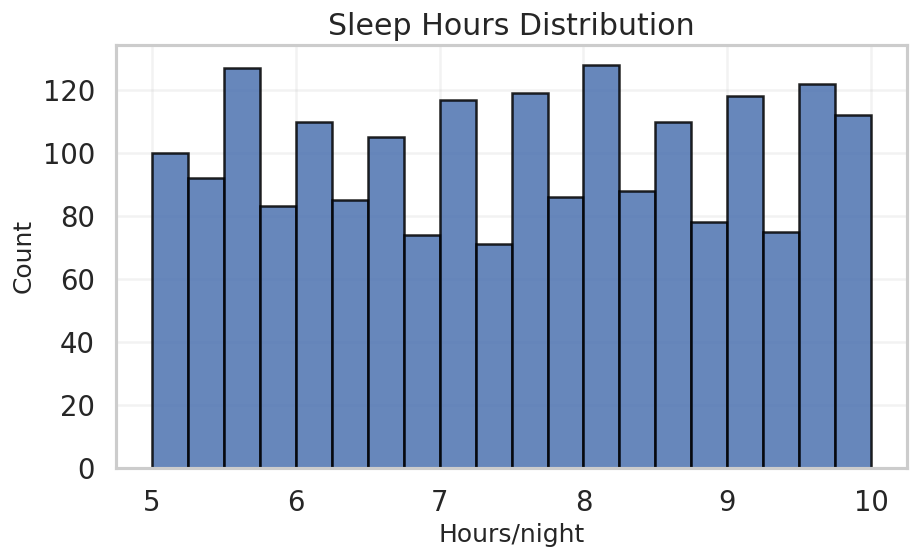

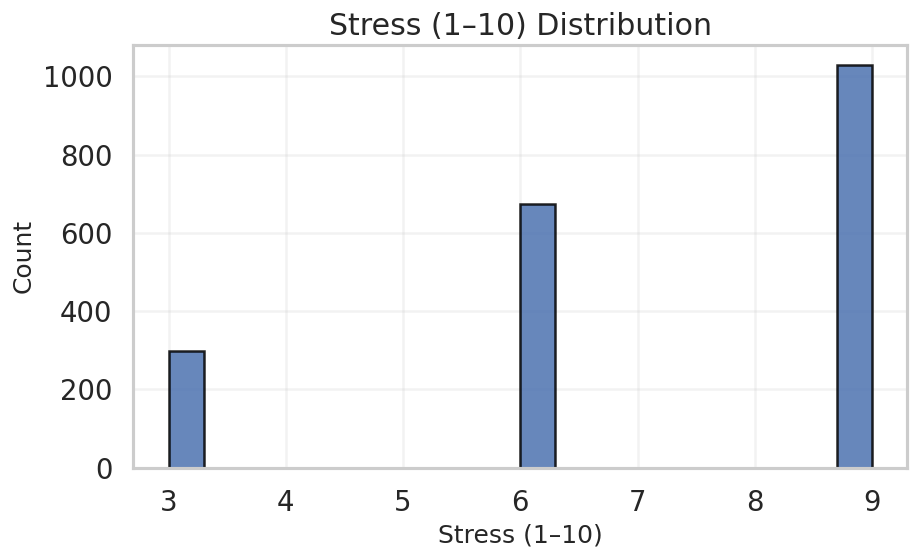

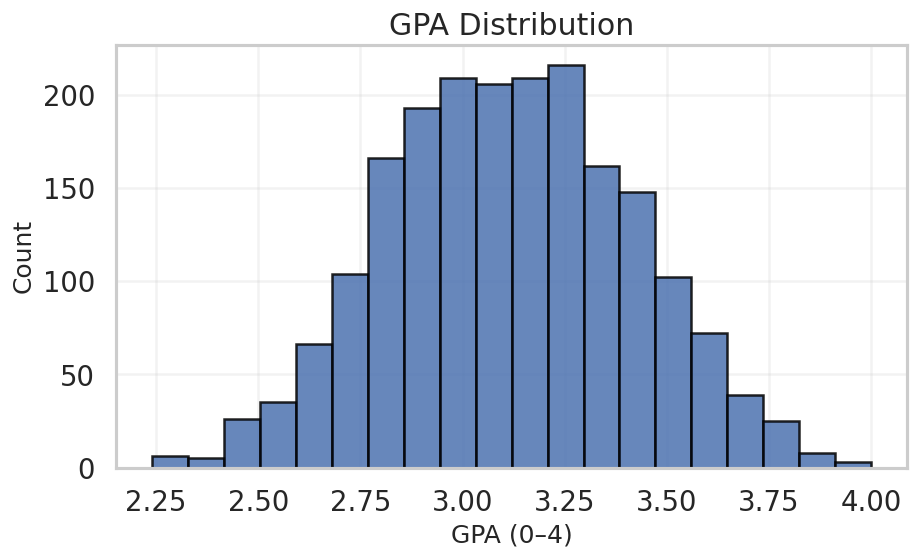

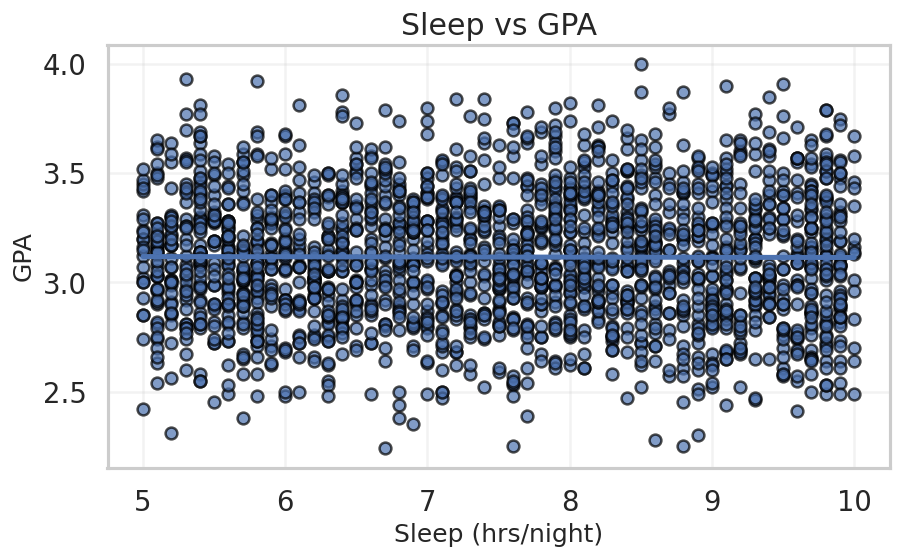

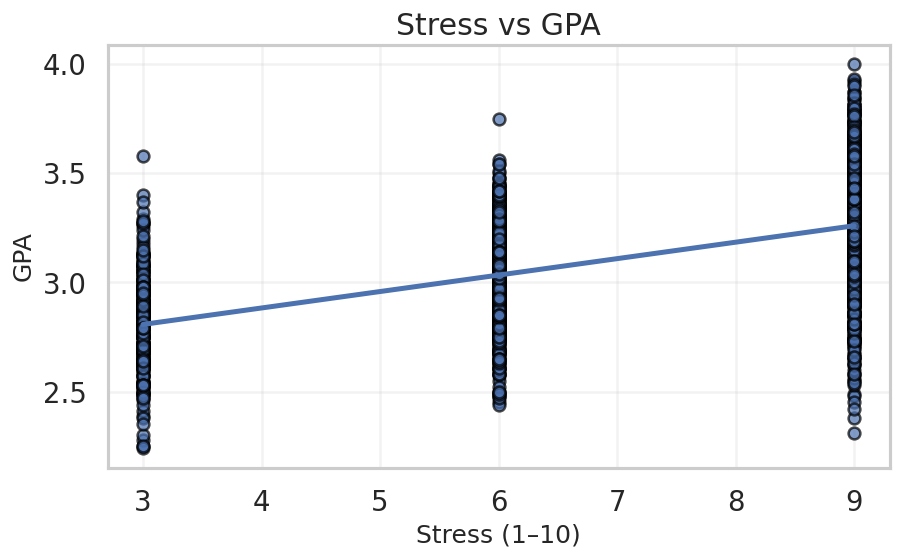

/tmp/ipython-input-3694128302.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  b = plt.boxplot(


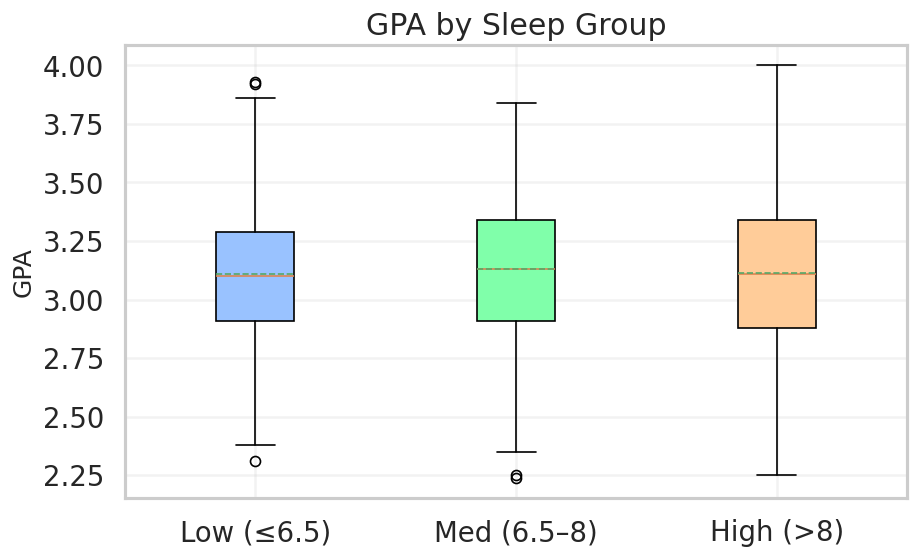

{'hist_sleep': '/content/figures/hist_sleep.png',
 'hist_stress': '/content/figures/hist_stress.png',
 'hist_gpa': '/content/figures/hist_gpa.png',
 'scatter_sleep_gpa': '/content/figures/scatter_sleep_gpa.png',
 'scatter_stress_gpa': '/content/figures/scatter_stress_gpa.png',
 'box_gpa_sleep': '/content/figures/box_gpa_sleep.png'}

In [ ]:
def save_hist(series, title, xlabel, fname):
    x = pd.to_numeric(series, errors='coerce').dropna()

    plt.figure()
    plt.hist(x, bins=20, alpha=0.85, edgecolor="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")

    plt.tight_layout()
    path = os.path.join(FIG_DIR, fname)
    plt.savefig(path, dpi=300)
    plt.show()

    return path


def save_scatter(x, y, title, xlabel, ylabel, fname, fit=True):
    x = pd.to_numeric(x, errors='coerce')
    y = pd.to_numeric(y, errors='coerce')

    mask = ~(x.isna() | y.isna())
    x, y = x[mask], y[mask]

    plt.figure()
    plt.scatter(x, y, s=50, alpha=0.7, edgecolors="black")

    if fit and len(x) >= 2:
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(float(x.min()), float(x.max()), 200)
        ys = m*xs + b
        plt.plot(xs, ys, linewidth=3)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.tight_layout()
    path = os.path.join(FIG_DIR, fname)
    plt.savefig(path, dpi=300)
    plt.show()

    return path


def save_box_by_sleep_groups(gpa, sleep, fname):
    g = pd.to_numeric(gpa, errors='coerce')
    s = pd.to_numeric(sleep, errors='coerce')
    mask = ~(g.isna() | s.isna())
    g, s = g[mask], s[mask]

    low  = g[s <= 6.5]
    med  = g[(s > 6.5) & (s <= 8.0)]
    high = g[s > 8.0]

    plt.figure()
    b = plt.boxplot(
        [low, med, high],
        labels=["Low (≤6.5)", "Med (6.5–8)", "High (>8)"],
        showmeans=True,
        meanline=True,
        patch_artist=True
    )

    colors = ["#99c2ff", "#80ffaa", "#ffcc99"]
    for patch, color in zip(b['boxes'], colors):
        patch.set_facecolor(color)

    plt.title("GPA by Sleep Group")
    plt.ylabel("GPA")

    plt.tight_layout()
    path = os.path.join(FIG_DIR, fname)
    plt.savefig(path, dpi=300)
    plt.show()

    return path


paths = {}
paths["hist_sleep"] = save_hist(work["sleep_hours"], "Sleep Hours Distribution", "Hours/night", "hist_sleep.png")
paths["hist_stress"] = save_hist(work["stress_10"], "Stress (1–10) Distribution", "Stress (1–10)", "hist_stress.png")
paths["hist_gpa"] = save_hist(work["gpa"], "GPA Distribution", "GPA (0–4)", "hist_gpa.png")
paths["scatter_sleep_gpa"] = save_scatter(work["sleep_hours"], work["gpa"], "Sleep vs GPA", "Sleep (hrs/night)", "GPA", "scatter_sleep_gpa.png")
paths["scatter_stress_gpa"] = save_scatter(work["stress_10"], work["gpa"], "Stress vs GPA", "Stress (1–10)", "GPA", "scatter_stress_gpa.png")
paths["box_gpa_sleep"] = save_box_by_sleep_groups(work["gpa"], work["sleep_hours"], "box_gpa_sleep.png")
paths


Saving Generated Outcomes

In [ ]:
results = {
    "meta": {"generated_at": datetime.utcnow().isoformat() + "Z", "csv_path": CSV_PATH},
    "descriptives": summ,
    "correlations": {
        "sleep_vs_gpa": {"r": r_sleep_gpa, "p": p_sleep_gpa},
        "stress_vs_gpa": {"r": r_stress_gpa, "p": p_stress_gpa}
    },
    "ttest_low_high_sleep": {"t": t_low_high, "p": p_low_high, "threshold_hours": 6.5,
                             "n_low": int(gpa_low.notna().sum()), "n_high": int(gpa_high.notna().sum())},
    "ols_regression": results_reg,
    "figures": {
        "hist_sleep": os.path.join(FIG_DIR, "hist_sleep.png"),
        "hist_stress": os.path.join(FIG_DIR, "hist_stress.png"),
        "hist_gpa": os.path.join(FIG_DIR, "hist_gpa.png"),
        "scatter_sleep_gpa": os.path.join(FIG_DIR, "scatter_sleep_gpa.png"),
        "scatter_stress_gpa": os.path.join(FIG_DIR, "scatter_stress_gpa.png"),
        "box_gpa_sleep": os.path.join(FIG_DIR, "box_gpa_sleep.png"),
    }
}
OUT_JSON = os.path.join(BASE_DIR, "results_summary.json")
with open(OUT_JSON, "w") as f:
    json.dump(results, f, indent=2)

print("Saved results JSON to:", OUT_JSON)
print("Figures saved to:", FIG_DIR)


Saved results JSON to: /content/results_summary.json
Figures saved to: /content/figures


/tmp/ipython-input-4060229381.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "meta": {"generated_at": datetime.utcnow().isoformat() + "Z", "csv_path": CSV_PATH},
